 <font size=6> **实验13 卷积神经网络**</font>

* 理解卷积神经网络的基本结构和工作原理，包括卷积层、池化层、全连接层等组成部分；
* 理解经典卷积神经网络架构LeNet，掌握在Pytorch中搭建、训练和测试模型；
* 掌握卷积神经网络LeNet在实际项目中的应用，逐步理解机器视觉的主流算法。

**(实验报告提交题3,4)** 前序实验从fetch_lfw_people数据集中选择了7位名人的脸部照片，采用softmax回归和MLP的方法做人脸分类，请使用Pytorch图像增强技术，采用旋转、翻转、裁剪、加入噪声等方式，将每张训练集的人脸照片生成50张新照片，扩充训练集的样本量。参考“6.6_卷积神经网络（LeNet）.ipynb”，按如下要求修改LeNet模型做人脸图片分类，调参并评估模型的预测效果。
- (1)图片大小为3×250×250，输出类别为7类；
- (2)第一层：填充padding为2；卷积为8个卷积核5×5；池化层窗口2、步长2，最大池化；
- (3)第二层：卷积为20个卷积核5×5；池化层窗口2、步长2 ，最大池化；
- (4)激活函数均为ReLU。

# 导入库

In [1]:
# 安装torchsummary
!pip install torchsummary -i https://mirrors.aliyun.com/pypi/simple/

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [57]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from d2l import torch as d2l
from d2l_ex import train_ch3
import torch
import torch.optim as optim
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils import data
from torch import nn
import torchsummary

# 数据处理

## 加载数据

数据增强transform方法参考代码
```python
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomVerticalFlip(),  # 随机垂直翻转
    transforms.RandomRotation(20),  # 随机旋转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机颜色调整
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),  # 20%的概率应用高斯模糊
    transforms.ToTensor()
])
```

In [23]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomVerticalFlip(),  # 随机垂直翻转
    transforms.RandomRotation(20),  # 随机旋转
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 随机颜色调整
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),  # 20%的概率应用高斯模糊
    transforms.ToTensor()
])

train_data = []
train_labels = []
test_data = []
test_labels = []
SIZE = 250
N = 2

for idx, pic_dir in enumerate(os.listdir('./pictures/')):
    train_path = os.path.join('./pictures', pic_dir, 'train')
    for filename in os.listdir(train_path):
        if filename.endswith('.jpg'):
            img = Image.open(os.path.join(train_path, filename))
            img = img.resize((SIZE, SIZE))  # 调整大小为 50x50
            img_tensor = ToTensor()(img)  # 转换为张量
            train_data.append(img_tensor)
            train_labels.append(idx)

            for _ in range(N):
                img_new = transform(img)
                train_data.append(img_new)
                train_labels.append(idx)

    test_path = os.path.join('./pictures', pic_dir, 'test')
    for filename in os.listdir(test_path):
        if filename.endswith('.jpg'):
            img = Image.open(os.path.join(test_path, filename))
            img = img.resize((SIZE, SIZE))  # 调整大小为 50x50
            img = ToTensor()(img)  # 转换为张量
            test_data.append(img)
            test_labels.append(idx)

# 创建 TensorDataset，所有图像都为大小 50x50
lfw_train = TensorDataset(torch.stack(train_data), torch.tensor(train_labels))
lfw_test = TensorDataset(torch.stack(test_data), torch.tensor(test_labels))

## 数据查看

In [4]:
len(lfw_train)

1008

In [5]:
lfw_train[0]

(tensor([[[0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0039, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1412, 0.1451, 0.1490,  ..., 0.0667, 0.0549, 0.0392],
          [0.1490, 0.1412, 0.1373,  ..., 0.0549, 0.0392, 0.0353],
          [0.1412, 0.1373, 0.1294,  ..., 0.0392, 0.0275, 0.0235]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.1882, 0.1922, 0.1961,  ..., 0.1098, 0.0980, 0.0824],
          [0.1961, 0.1882, 0.1843,  ..., 0.0980, 0.0824, 0.0784],
          [0.1882, 0.1843, 0.1765,  ..., 0.0824, 0.0706, 0.0667]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

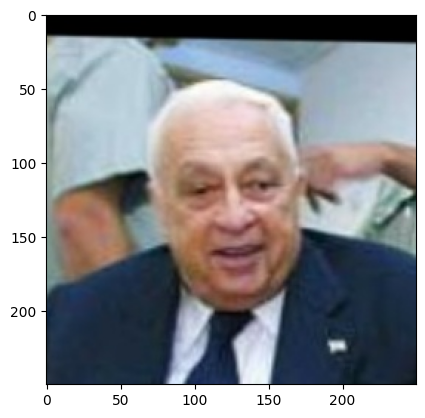

In [7]:
plt.imshow(lfw_train[0][0].permute(1, 2, 0))

# 建模

## 定义网络结构

In [8]:
net = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(8, 20, kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(20 * 60 * 60, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 7))

## 查看网络结构和参数量

In [9]:
X = torch.rand(size=(1, 3, SIZE, SIZE), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 8, 250, 250])
ReLU output shape:	 torch.Size([1, 8, 250, 250])
MaxPool2d output shape:	 torch.Size([1, 8, 125, 125])
Conv2d output shape:	 torch.Size([1, 20, 121, 121])
ReLU output shape:	 torch.Size([1, 20, 121, 121])
MaxPool2d output shape:	 torch.Size([1, 20, 60, 60])
Flatten output shape:	 torch.Size([1, 72000])
Linear output shape:	 torch.Size([1, 120])
ReLU output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
ReLU output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 7])


In [10]:
torchsummary.summary(net, input_size=(3, SIZE, SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 250, 250]             608
              ReLU-2          [-1, 8, 250, 250]               0
         MaxPool2d-3          [-1, 8, 125, 125]               0
            Conv2d-4         [-1, 20, 121, 121]           4,020
              ReLU-5         [-1, 20, 121, 121]               0
         MaxPool2d-6           [-1, 20, 60, 60]               0
           Flatten-7                [-1, 72000]               0
            Linear-8                  [-1, 120]       8,640,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                    [-1, 7]             595
Total params: 8,655,507
Trainable params: 8,655,507
Non-trainable params: 0
---------------------------


## 模型训练

loss 0.760, train acc 0.724, test acc 0.524
98.9 examples/sec on cpu


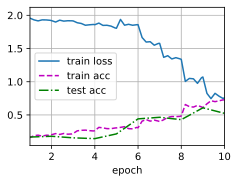

In [24]:
batch_size = 32
train_iter = data.DataLoader(lfw_train, batch_size, shuffle=True)
test_iter = data.DataLoader(lfw_test, batch_size, shuffle=True)

lr = 0.05
num_epochs = 10

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 预测

In [42]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        try:
            img = d2l.numpy(img)
        except:
            pass
        img = img.swapaxes(0, 1).swapaxes(1, 2)
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


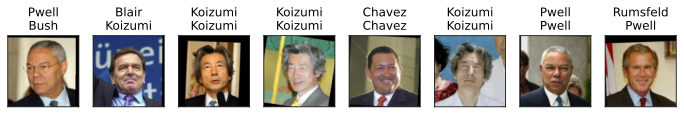

In [46]:
def get_lfw_labels(labels):
    text_labels = ['Sharon', 'Pwell', 'Bush', 'Rumsfeld', 'Blair', 'Chavez', 'Koizumi']
    return [text_labels[int(i)] for i in labels]

def predict(net, test_iter, n=8):
    for X, y in test_iter:
        break
    trues = get_lfw_labels(y)
    preds = get_lfw_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 3, SIZE, SIZE)), 1, n, titles=titles[0:n])

net.to('cpu')
predict(net, test_iter)

## 提高题

In [51]:
class ModifiedLeNet(nn.Module):
    def __init__(self):
        super(ModifiedLeNet, self).__init__()
        # 第一个卷积层块
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # 第二个卷积层块
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # 计算全连接层的输入维度
        # 经过两次MaxPool2d，图片尺寸变为原来的1/4
        self.fc_input_dim = 20 * 61 * 61
        
        # 全连接层
        self.fc = nn.Sequential(
            nn.Linear(self.fc_input_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 7)  # 7个类别的输出
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.fc(x)
        return x

In [52]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model = model.to(device)
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        
        # 测试阶段
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        test_acc = 100. * correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {running_loss/len(train_loader):.3f}')
        print(f'Training Accuracy: {train_acc:.2f}%')
        print(f'Test Accuracy: {test_acc:.2f}%')
        print('-' * 50)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    return best_acc

In [53]:
def main():
    # 设置随机种子
    torch.manual_seed(42)
    
    # 数据加载
    batch_size = 32
    train_loader = DataLoader(lfw_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(lfw_test, batch_size=batch_size)
    
    # 创建模型
    model = ModifiedLeNet()
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练模型
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_acc = train_model(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=20,
        device=device
    )
    
    print(f'Accuracy: {best_acc:.2f}%')
